# Contents and geometry of boreholes
This notebook prototypes method that can extract geometric information about boreholes and their intersection objects.

In [8]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend([
    'C:/Users/Haakon/OneDrive/Dokumenter/FORSKNING/mastersproject/src/mastersproject',
    'C:/Users/Haakon/OneDrive/Dokumenter/FORSKNING/mastersproject/src/mastersproject/GTS'
])

# Notebook images
from IPython.display import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from GTS.ISC_data.isc import ISCData
import numpy as np
import pandas as pd

In [10]:
cls = ISCData()

## Borehole data
First, let's consider coordinates and orientations of the root of each borehole

In [11]:
bh_geom = cls.borehole_data()
bh_geom.head()

,x,y,z,length,diameter,azimuth,upward_gradient,borehole
0,667466.424,158888.882,1732.782,44.80,101,317.05,-31.92,FBS1
1,667470.633,158905.016,1732.725,47.58,101,253.07,-40.46,FBS2
2,667471.317,158926.213,1732.263,44.00,101,219.92,-37.33,FBS3
3,667470.546,158859.278,1746.458,18.20,101,258.89,-75.13,SBH1
4,667468.567,158885.383,1733.960,20.55,101,190.07,4.91,SBH3


In [12]:
struc_intx = cls.borehole_structure_data()
struc_intx.head()

,depth,azimuth,dip,aperture,type,borehole
0,2.35,169.30,57.47,334.61,Minor ductile Shear-zone,FBS1
1,2.99,162.65,58.83,35.70,Minor ductile Shear-zone,FBS1
2,3.27,172.09,58.07,0.00,Foliation,FBS1
3,5.02,163.86,61.26,578.25,Minor ductile Shear-zone,FBS1
4,6.76,169.90,66.49,0.00,Foliation,FBS1


## Our aim is to convert the relative coordinates of a structure to global Swiss coordinates.

The following formula applies:

\begin{equation}
\begin{bmatrix}
struc_x\\ struc_y\\ struc_z\\
\end{bmatrix}
= \begin{bmatrix}
bh_x\\ bh_y \\ bh_z
\end{bmatrix}
+ depth(struc)
\cdot \begin{bmatrix}
\cos\theta \sin \gamma \\
\cos \theta \cos \gamma \\
\sin \theta \\
\end{bmatrix}
\end{equation}

Noting the following variables: \
$struc$ is the structure under consideration (e.g. a shearzone). \
$bh$ is the coordinates of the borehole \
$depth(struc)$ is depth of the structure in the borehole. \
$\theta$ is upward gradient of borehole\
$\gamma$ is the azimuth of borehole

In [13]:
def swiss_to_gts(v):
    """ Convert from swiss coordinates to gts coordinates
    
    GTS coordinates are: (x,y,z) = (667400, 158800, 1700)
    
    Parameters:
    v (np.array (3,)): Coordinate array
    
    """
    return v - np.array([667400, 158800, 1700])

## Testing
Informal testing. Verify endpoints of boreholes visually using matplot visualization tool

In [14]:
#GEO
wells = ['GEO1', 'GEO2', 'GEO3', 'GEO4']
geo = bh_geom[bh_geom['borehole'].isin(wells)]
geo

# Calculate the trigonometric scaling
rad = np.pi/180
geo.loc[:, '_angles_x'] = (geo['upward_gradient'] * rad).apply(np.cos) * \
                          (geo['azimuth'] * rad).apply(np.sin)

geo.loc[:, '_angles_y'] = (geo['upward_gradient'] * rad).apply(np.cos) * \
                          (geo['azimuth'] * rad).apply(np.cos)

geo.loc[:, '_angles_z'] = (geo['upward_gradient'] * rad).apply(np.sin)

# Calculate swiss coordinates
geo.loc[:, 'x_swiss'] = geo['x'] + (geo['length'] * geo['_angles_x'])
geo.loc[:, 'y_swiss'] = geo['y'] + (geo['length'] * geo['_angles_y'])
geo.loc[:, 'z_swiss'] = geo['z'] + (geo['length'] * geo['_angles_z'])

# Calculate GTS coordinates
geo[['x_gts', 'y_gts', 'z_gts']] = \
geo[['x_swiss', 'y_swiss', 'z_swiss']].apply(swiss_to_gts, axis=1, raw=True, result_type='expand')


geo

c:\users\haakon\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\haakon\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\haakon\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a 

,x,y,z,length,diameter,azimuth,upward_gradient,borehole,_angles_x,_angles_y,_angles_z,x_swiss,y_swiss,z_swiss,x_gts,y_gts,z_gts
11,667470.730,158896.006,1732.364,30.26,86,270.33,-47.79,GEO1,-0.671839,0.003870,-0.740687,667450.400160,158896.123093,1709.950801,50.400160,96.123093,9.950801
12,667470.589,158896.008,1732.496,40.09,86,270.03,-34.20,GEO2,-0.827080,0.000433,-0.562083,667437.431344,158896.025361,1709.962077,37.431344,96.025361,9.962077
13,667470.923,158912.008,1732.416,30.10,86,269.96,-47.80,GEO3,-0.671720,-0.000469,-0.740805,667450.704215,158911.993885,1710.117782,50.704215,111.993885,10.117782
14,667470.776,158912.000,1732.618,40.05,86,270.03,-34.22,GEO4,-0.826884,0.000433,-0.562372,667437.659288,158912.017340,1710.094999,37.659288,112.017340,10.094999


# Make the testing above into a method

In [15]:
def bh_struc_to_global_coords(data: pd.DataFrame, *,
                             x: str, y: str, z: str, depth: str, 
                             upward_gradient: str, azimuth: str,
                            ):
    """ Convert coordinates in a borehole to global coordinates
    
    For all rows in a DataFrame, convert some (x,y,z) coordinates to global
    coordinates, localized to Swiss and/or GTS.
    
    Parameters:
    data (pd.DataFrame)
    x, y, z, depth, upward_gradient, azimuth (str): 
        Column names for the respective quantities
    """

    # Compute angle scalers
    rad = np.pi / 180
    data.loc[:, '_trig_x'] = (data[upward_gradient] * rad).apply(np.cos) * \
                             (data[azimuth] * rad).apply(np.sin)

    data.loc[:, '_trig_y'] = (data[upward_gradient] * rad).apply(np.cos) * \
                             (data[azimuth] * rad).apply(np.cos)

    data.loc[:, '_trig_z'] = (data[upward_gradient] * rad).apply(np.sin)
    
    # Swiss coordinates
    data.loc[:, 'x_swiss'] = data[x] + (data[depth] * data['_trig_x'])
    data.loc[:, 'y_swiss'] = data[y] + (data[depth] * data['_trig_y'])
    data.loc[:, 'z_swiss'] = data[z] + (data[depth] * data['_trig_z'])
    
    # GTS coordinates
    data[['x_gts', 'y_gts', 'z_gts']] = \
    data[['x_swiss', 'y_swiss', 'z_swiss']].apply(swiss_to_gts, axis=1, 
                                                 raw=True, result_type='expand')



## Test the unified method 

In [16]:
geo

,x,y,z,length,diameter,azimuth,upward_gradient,borehole,_angles_x,_angles_y,_angles_z,x_swiss,y_swiss,z_swiss,x_gts,y_gts,z_gts
11,667470.730,158896.006,1732.364,30.26,86,270.33,-47.79,GEO1,-0.671839,0.003870,-0.740687,667450.400160,158896.123093,1709.950801,50.400160,96.123093,9.950801
12,667470.589,158896.008,1732.496,40.09,86,270.03,-34.20,GEO2,-0.827080,0.000433,-0.562083,667437.431344,158896.025361,1709.962077,37.431344,96.025361,9.962077
13,667470.923,158912.008,1732.416,30.10,86,269.96,-47.80,GEO3,-0.671720,-0.000469,-0.740805,667450.704215,158911.993885,1710.117782,50.704215,111.993885,10.117782
14,667470.776,158912.000,1732.618,40.05,86,270.03,-34.22,GEO4,-0.826884,0.000433,-0.562372,667437.659288,158912.017340,1710.094999,37.659288,112.017340,10.094999


In [17]:
mapping = {'x': 'x', 'y': 'y', 'z': 'z', 'depth': 'length', 
           'upward_gradient': 'upward_gradient', 'azimuth': 'azimuth'}
bh_struc_to_global_coords(geo, **mapping)

In [18]:
geo[['borehole', 'x_gts', 'y_gts', 'z_gts']]

,borehole,x_gts,y_gts,z_gts
11,GEO1,50.400160,96.123093,9.950801
12,GEO2,37.431344,96.025361,9.962077
13,GEO3,50.704215,111.993885,10.117782
14,GEO4,37.659288,112.017340,10.094999


## Success!
Confirmed by checking with the matlab visualization.

(Compare values above with coordinated in image below)

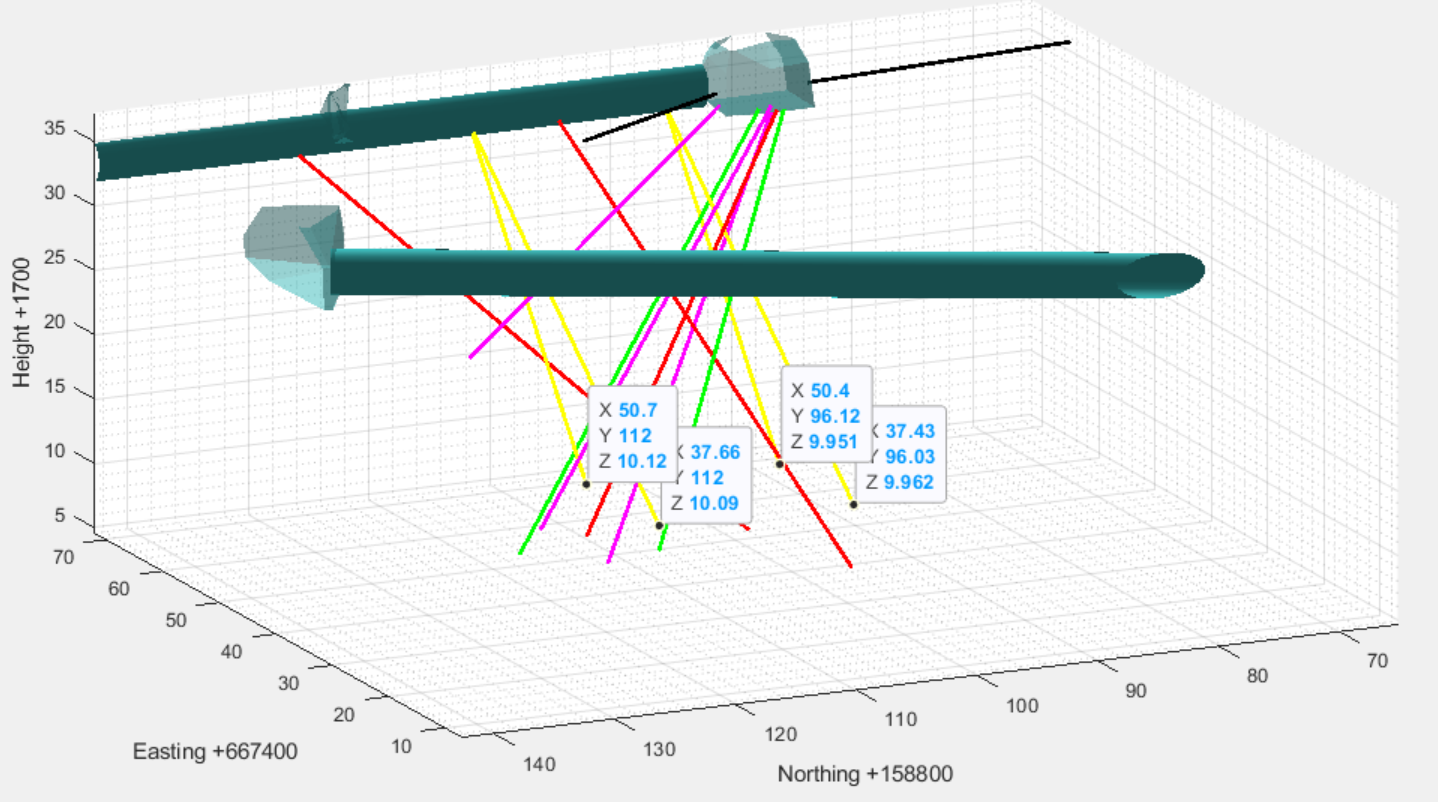

# Finally, do this for all borehole endpoints 

In [19]:
mapping = {'x': 'x', 'y': 'y', 'z': 'z', 'depth': 'length', 
           'upward_gradient': 'upward_gradient', 'azimuth': 'azimuth'}
bh_struc_to_global_coords(bh_geom, **mapping)
bh_geom

,x,y,z,length,diameter,azimuth,upward_gradient,borehole,_trig_x,_trig_y,_trig_z,x_swiss,y_swiss,z_swiss,x_gts,y_gts,z_gts
0,667466.424,158888.882,1732.782,44.80,101,317.05,-31.92,FBS1,-0.578330,0.621269,-0.528735,667440.514837,158916.714832,1709.094688,40.514837,116.714832,9.094688
1,667470.633,158905.016,1732.725,47.58,101,253.07,-40.46,FBS2,-0.727884,-0.221565,-0.648917,667436.000256,158894.473957,1701.849528,36.000256,94.473957,1.849528
2,667471.317,158926.213,1732.263,44.00,101,219.92,-37.33,FBS3,-0.510265,-0.609838,-0.606405,667448.865319,158899.380130,1705.581188,48.865319,99.380130,5.581188
3,667470.546,158859.278,1746.458,18.20,101,258.89,-75.13,SBH1,-0.251817,-0.049450,-0.966511,667465.962925,158858.378006,1728.867507,65.962925,58.378006,28.867507
4,667468.567,158885.383,1733.960,20.55,101,190.07,4.91,SBH3,-0.174210,-0.980982,0.085591,667464.986993,158865.223825,1735.718891,64.986993,65.223825,35.718891
5,667468.729,158892.774,1733.910,23.90,101,320.00,5.00,SBH4,-0.640342,0.763129,0.087156,667453.424836,158911.012793,1735.993022,53.424836,111.012793,35.993022
6,667466.231,158888.399,1732.817,44.66,146,309.57,-33.52,INJ1,-0.642650,0.531080,-0.552228,667437.530263,158912.117014,1708.154496,37.530263,112.117014,8.154496
7,667466.787,158890.217,1732.881,44.80,146,332.28,-43.65,INJ2,-0.336569,0.640527,-0.690251,667451.708697,158918.912593,1701.957744,51.708697,118.912593,1.957744
8,667466.510,158889.310,1732.640,47.91,131,320.00,-44.00,PRP1,-0.462383,0.551046,-0.694658,667444.357244,158915.710626,1699.358917,44.357244,115.710626,-0.641083
9,667466.510,158889.310,1733.120,44.98,131,321.99,-31.99,PRP2,-0.522284,0.668253,-0.529771,667443.017660,158919.368008,1709.290889,43.017660,119.368008,9.290889


# Extract global coordinates for all intersecting structures 
Use the method `borehole_structure_data()` to extract information about relative location of
all structures observed within a borehole.


This data will be combined with the borehole geometry data to calculate global coordinates of all structures

In [20]:
struc_intx = cls.borehole_structure_data()
struc_intx.head()

,depth,azimuth,dip,aperture,type,borehole
0,2.35,169.30,57.47,334.61,Minor ductile Shear-zone,FBS1
1,2.99,162.65,58.83,35.70,Minor ductile Shear-zone,FBS1
2,3.27,172.09,58.07,0.00,Foliation,FBS1
3,5.02,163.86,61.26,578.25,Minor ductile Shear-zone,FBS1
4,6.76,169.90,66.49,0.00,Foliation,FBS1


In [21]:
bh_geom = cls.borehole_data()
bh_geom.head()

,x,y,z,length,diameter,azimuth,upward_gradient,borehole
0,667466.424,158888.882,1732.782,44.80,101,317.05,-31.92,FBS1
1,667470.633,158905.016,1732.725,47.58,101,253.07,-40.46,FBS2
2,667471.317,158926.213,1732.263,44.00,101,219.92,-37.33,FBS3
3,667470.546,158859.278,1746.458,18.20,101,258.89,-75.13,SBH1
4,667468.567,158885.383,1733.960,20.55,101,190.07,4.91,SBH3


### Merge the two tables along the `borehole` column

In [22]:
struc_intx = cls.borehole_structure_data().merge(cls.borehole_data(), 
                                                 how='outer', 
                                                 on='borehole',
                                                 suffixes=('_struc', '_bh'), 
                                                 validate='m:1')

struc_intx

,depth,azimuth_struc,dip,aperture,type,borehole,x,y,z,length,diameter,azimuth_bh,upward_gradient
0,2.35,169.30,57.47,334.61,Minor ductile Shear-zone,FBS1,667466.424,158888.882,1732.782,44.80,101,317.05,-31.92
1,2.99,162.65,58.83,35.70,Minor ductile Shear-zone,FBS1,667466.424,158888.882,1732.782,44.80,101,317.05,-31.92
2,3.27,172.09,58.07,0.00,Foliation,FBS1,667466.424,158888.882,1732.782,44.80,101,317.05,-31.92
3,5.02,163.86,61.26,578.25,Minor ductile Shear-zone,FBS1,667466.424,158888.882,1732.782,44.80,101,317.05,-31.92
4,6.76,169.90,66.49,0.00,Foliation,FBS1,667466.424,158888.882,1732.782,44.80,101,317.05,-31.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,36.12,163.97,74.71,0.00,Fracture,GEO4,667470.776,158912.000,1732.618,40.05,86,270.03,-34.22
587,36.22,164.61,72.02,0.00,Fracture,GEO4,667470.776,158912.000,1732.618,40.05,86,270.03,-34.22
588,36.31,168.60,64.36,0.00,Fracture,GEO4,667470.776,158912.000,1732.618,40.05,86,270.03,-34.22
589,38.32,160.06,74.77,0.00,Fracture,GEO4,667470.776,158912.000,1732.618,40.05,86,270.03,-34.22


### Find global coordinates for each structure 

In [23]:
mapping = {'x': 'x', 'y': 'y', 'z': 'z', 'depth': 'depth', 
           'upward_gradient': 'upward_gradient', 'azimuth': 'azimuth_bh'}
bh_struc_to_global_coords(struc_intx, **mapping)
struc_intx

,depth,azimuth_struc,dip,aperture,type,borehole,x,y,z,length,...,upward_gradient,_trig_x,_trig_y,_trig_z,x_swiss,y_swiss,z_swiss,x_gts,y_gts,z_gts
0,2.35,169.30,57.47,334.61,Minor ductile Shear-zone,FBS1,667466.424,158888.882,1732.782,44.80,...,-31.92,-0.578330,0.621269,-0.528735,667465.064926,158890.341981,1731.539474,65.064926,90.341981,31.539474
1,2.99,162.65,58.83,35.70,Minor ductile Shear-zone,FBS1,667466.424,158888.882,1732.782,44.80,...,-31.92,-0.578330,0.621269,-0.528735,667464.694795,158890.739593,1731.201083,64.694795,90.739593,31.201083
2,3.27,172.09,58.07,0.00,Foliation,FBS1,667466.424,158888.882,1732.782,44.80,...,-31.92,-0.578330,0.621269,-0.528735,667464.532862,158890.913548,1731.053038,64.532862,90.913548,31.053038
3,5.02,163.86,61.26,578.25,Minor ductile Shear-zone,FBS1,667466.424,158888.882,1732.782,44.80,...,-31.92,-0.578330,0.621269,-0.528735,667463.520786,158892.000768,1730.127752,63.520786,92.000768,30.127752
4,6.76,169.90,66.49,0.00,Foliation,FBS1,667466.424,158888.882,1732.782,44.80,...,-31.92,-0.578330,0.621269,-0.528735,667462.514492,158893.081776,1729.207754,62.514492,93.081776,29.207754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,36.12,163.97,74.71,0.00,Fracture,GEO4,667470.776,158912.000,1732.618,40.05,...,-34.22,-0.826884,0.000433,-0.562372,667440.908942,158912.015638,1712.305122,40.908942,112.015638,12.305122
587,36.22,164.61,72.02,0.00,Fracture,GEO4,667470.776,158912.000,1732.618,40.05,...,-34.22,-0.826884,0.000433,-0.562372,667440.826254,158912.015682,1712.248884,40.826254,112.015682,12.248884
588,36.31,168.60,64.36,0.00,Fracture,GEO4,667470.776,158912.000,1732.618,40.05,...,-34.22,-0.826884,0.000433,-0.562372,667440.751834,158912.015721,1712.198271,40.751834,112.015721,12.198271
589,38.32,160.06,74.77,0.00,Fracture,GEO4,667470.776,158912.000,1732.618,40.05,...,-34.22,-0.826884,0.000433,-0.562372,667439.089797,158912.016591,1711.067903,39.089797,112.016591,11.067903


In [24]:
struc_intx.columns

Index(['depth', 'azimuth_struc', 'dip', 'aperture', 'type', 'borehole', 'x',
       'y', 'z', 'length', 'diameter', 'azimuth_bh', 'upward_gradient',
       '_trig_x', '_trig_y', '_trig_z', 'x_swiss', 'y_swiss', 'z_swiss',
       'x_gts', 'y_gts', 'z_gts'],
      dtype='object')

In [25]:
np.unique(struc_intx['type'].to_numpy())

array(['Biotite Band', 'Foliation', 'Fracture',
       'Minor ductile Shear-zone', 'Quartz', 'S1 Shear-zone',
       'S3 Shear-zone'], dtype=object)

In [26]:
s1 = struc_intx[struc_intx['type'] == 'S3 Shear-zone']
s1[['type', 'borehole', 'x_gts', 'y_gts', 'z_gts']].head()

,type,borehole,x_gts,y_gts,z_gts
18,S3 Shear-zone,FBS1,52.925789,103.382408,20.441333
29,S3 Shear-zone,FBS1,50.329089,106.171904,18.067315
34,S3 Shear-zone,FBS1,49.785460,106.755897,17.570304
113,S3 Shear-zone,FBS3,54.763988,106.429857,12.591227
114,S3 Shear-zone,FBS3,54.279236,105.850511,12.015143


## Light verification
Consider the two points below:
The left one is a red borehole (FBS) intersecting an S3 shear-zone. \
The right one is a yellow borehole (GEO) intersecting an S1 shear-zone.

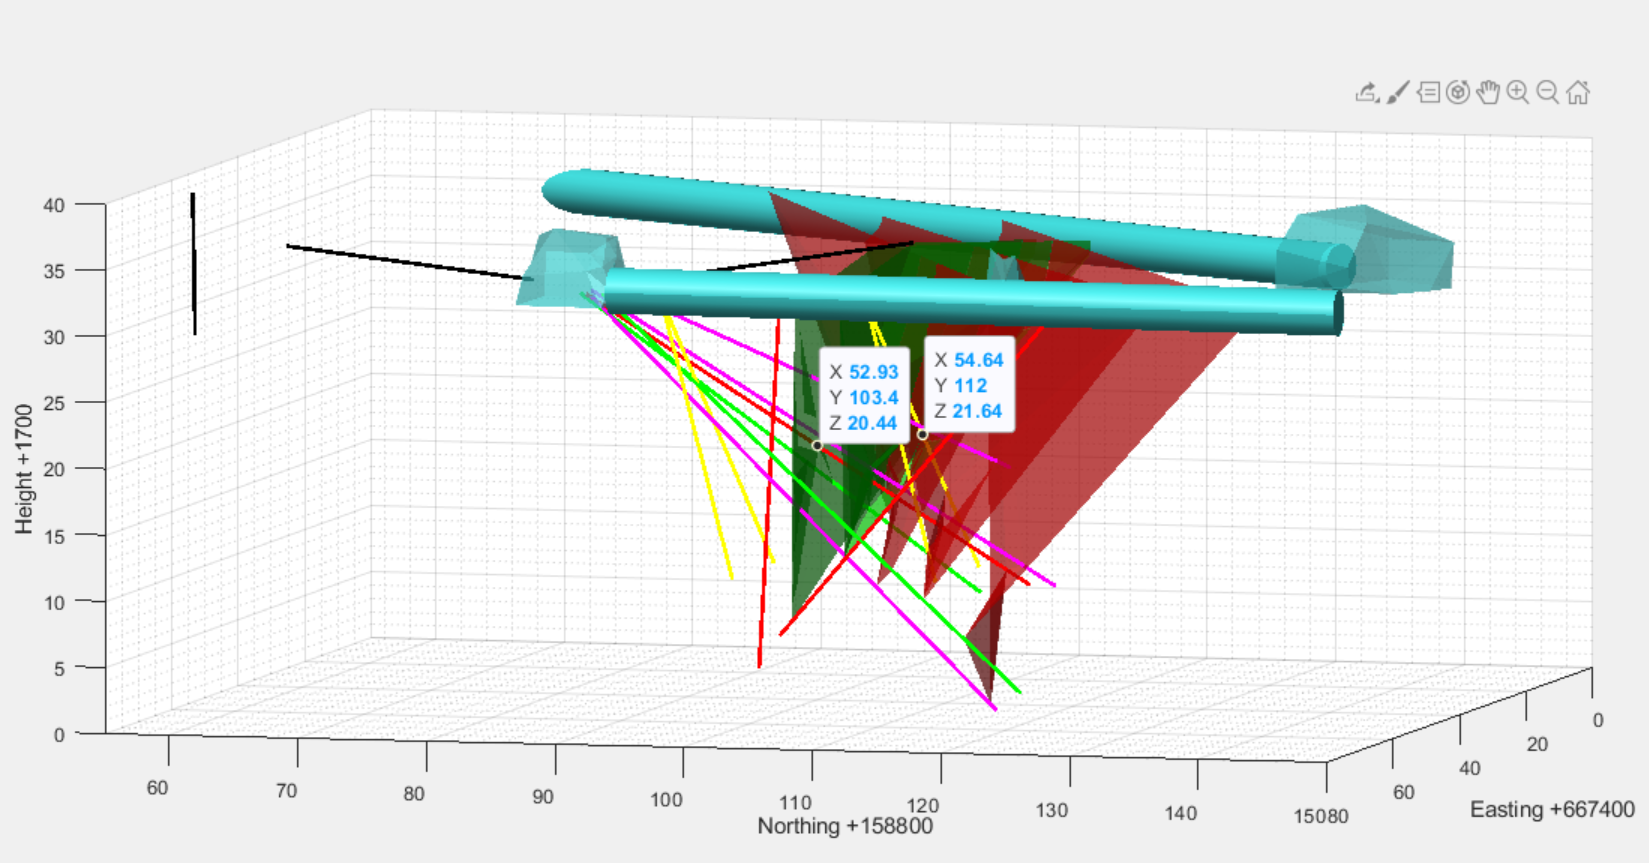

In [27]:
# Intersection of FBS and S3 Shear-zone
struc_intx[['type', 'borehole', 'x_gts', 'y_gts', 'z_gts']].loc[18]

type        S3 Shear-zone
borehole             FBS1
x_gts             52.9258
y_gts             103.382
z_gts             20.4413
Name: 18, dtype: object

In [28]:
# Intersection of GEO and S1 Shear-zone
struc_intx[['type', 'borehole', 'x_gts', 'y_gts', 'z_gts']].loc[568]

type        S1 Shear-zone
borehole             GEO4
x_gts             54.6352
y_gts             112.008
z_gts             21.6405
Name: 568, dtype: object